In [1]:
from fastai.collab import *
from fastai.tabular import *
import numpy as np
import matplotlib.pylab as plt
from scipy import stats

In [2]:
def get_data(path, standard_type = 'KD', standard_unit='NM', transformation = None):
    df_all = pd.read_csv(path, usecols=['compound_id', 'target_id',
                                        'standard_type', 'standard_relation', 'standard_value', 'standard_units'])
    df_filtered = df_all[df_all.standard_value!=0].copy()
    df_filtered = df_filtered[(df_all.standard_type==standard_type) & 
                              (df_all.standard_relation=='=') &
                              (df_all.standard_units==standard_unit)].dropna().copy()
    df_filtered = df_filtered[~df_filtered.target_id.str.contains(',')]
    if transformation == None:
        target_name = standard_type
        df_filtered[target_nanme] = df_filtered['standard_value']
    else:
        target_name = standard_type + transformation.__name__
        df_filtered[target_name] = transformation(df_filtered['standard_value'])
    
    return df_filtered, target_name

In [3]:
def plot_preds(pred, target, target_name='target'):
    # plot a comparison between prediction and actual result
    fig, ax = plt.subplots(1, 2)
    axis_min = np.min([np.array(pred).flatten().min(), np.array(target).flatten().min()])
    axis_max = np.max([np.array(pred).flatten().max(), np.array(target).flatten().max()])
    ax[0].scatter(pred, target, alpha=0.02)
    ax[0].set_xlim([axis_min, axis_max])
    ax[0].set_xlabel(target_name + ' prediction')
    ax[0].set_ylim([axis_min, axis_max])
    ax[0].set_ylabel(target_name + ' actual')
    ax[0].set_aspect('equal')
    slope, intercept, r_value, p_value, std_err = stats.linregress(pred, target.flatten())
    ax[0].set_title("r_squared: {}".format(r_value**2) + "slope: {}".format(slope))
    ax[1].hist(np.array(pred).flatten()-np.array(target).flatten(), np.linspace(-10, 10, 100))
    ax[1].set_title('Histogram of prediction-target')

In [4]:
path = Path('/home/jupyter/.fastai/data/kinase/DTC_data.csv')

In [32]:
columns = df_DTC.columns; columns

Index(['compound_id', 'standard_inchi_key', 'compound_name', 'synonym',
       'target_id', 'target_pref_name', 'gene_names', 'wildtype_or_mutant',
       'mutation_info', 'pubmed_id', 'standard_type', 'standard_relation',
       'standard_value', 'standard_units', 'activity_comment',
       'ep_action_mode', 'assay_format', 'assaytype', 'assay_subtype',
       'inhibitor_type', 'detection_tech', 'assay_cell_line',
       'compound_concentration_value', 'compound_concentration_value_unit',
       'substrate_type', 'substrate_relation', 'substrate_value',
       'substrate_units', 'assay_description', 'title', 'journal', 'doc_type',
       'annotation_comments'],
      dtype='object')

In [5]:
df_Kd, target_name = get_data(path, standard_type='KD', standard_unit='NM', transformation=np.log)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [6]:
df_Kd.tail()

,compound_id,target_id,standard_type,standard_relation,standard_value,standard_units,KDlog
5932528,CHEMBL3545051,P36888,KD,=,74.0,NM,4.304065
5959350,CHEMBL3545051,P10721,KD,=,280.0,NM,5.634790
5971861,CHEMBL3545051,P00533,KD,=,140.0,NM,4.941642
5971862,CHEMBL3545051,P00533,KD,=,25.0,NM,3.218876
5977267,CHEMBL3545267,O35904,KD,=,6.2,NM,1.824549


In [7]:
df_Kd.shape

(32536, 7)

In [8]:
df_Kd[target_name].describe()

count    32536.000000
mean         5.383024
std          3.440766
min        -18.420681
25%          2.995732
50%          5.703782
75%          7.649693
max         25.328436
Name: KDlog, dtype: float64

In [9]:
df_Kd.standard_units.unique()

array(['NM'], dtype=object)

# Generate data

In [10]:
Kd_data = CollabDataBunch.from_df(df_Kd, user_name='compound_id',
                                         item_name='target_id',
                                         rating_name=target_name, 
                                         pct_val=0.1,
                                         seed=40)

In [11]:
Kd_data.show_batch()

compound_id,target_id,target
CHEMBL1287853,P10721,4.060442924499512
CHEMBL574738,Q8IVH8,5.247024059295654
CHEMBL103667,P07947,8.496990203857422
CHEMBL513909,Q8NEV4,8.748305320739746
CHEMBL1075957,Q99816,11.08214282989502


# Model using embedding

In [12]:
Kd_learn = collab_learner(Kd_data, n_factors=20, y_range=[-15, 25])

In [13]:
Kd_learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


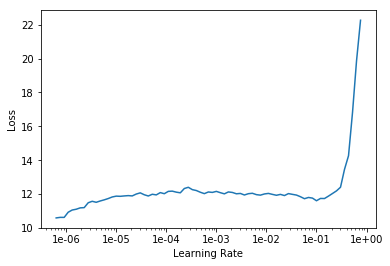

In [14]:
Kd_learn.recorder.plot()

In [15]:
Kd_learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss
1,7.975930,7.499117
2,4.710586,5.447223
3,2.571797,5.114193
4,1.586260,5.029749
5,0.944708,5.015110


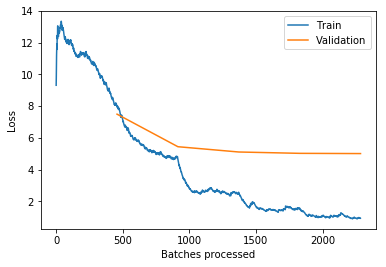

In [16]:
Kd_learn.recorder.plot_losses()

In [17]:
Kd_learn.show_results(rows=10)

compound_id,target_id,target,prediction
CHEMBL428690,Q15303,8.517192840576172,8.34719467163086
#na#,Q63844,-1.272965669631958,1.3878021240234375
#na#,P31389,1.381281852722168,5.572265625
CHEMBL535,Q96SB4,5.521461009979248,5.657947540283203
CHEMBL464552,P49760,2.7725887298583984,6.140544891357422
#na#,Q99816,10.878046989440918,9.60898208618164
CHEMBL601719,O43318,7.495542049407959,7.556001663208008
CHEMBL1233735,Q8N1Q1,3.332204580307007,4.36895751953125
#na#,P9WNS1,4.499809741973877,4.658700942993164
#na#,A1XG20,5.438079357147217,5.396139144897461


In [18]:
Kd_preds = Kd_learn.get_preds(ds_type=DatasetType.Valid)

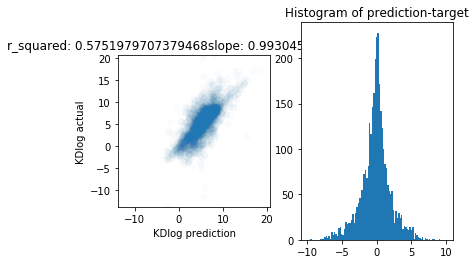

In [19]:
plot_preds(Kd_preds[0], Kd_preds[1], target_name)

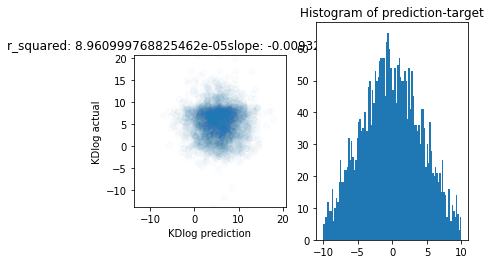

In [20]:
# bench mark: no prediction at all
random_preds = (np.random.randn(len(Kd_preds[1]))*df_Kd[target_name].describe()['std']+
                df_Kd[target_name].describe()['mean'])
plot_preds(random_preds, Kd_preds[1], target_name)

### There are a bunch of #na# in validation set for compound id. This is because these compounds were not found in the training dataset. For simplicity, let's ignore them for now. The result (r2) improves as expected.

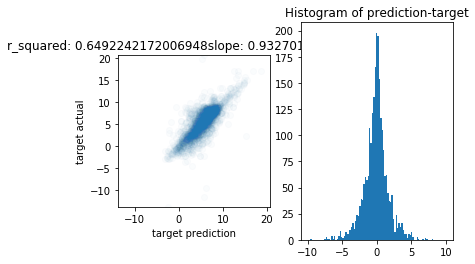

In [21]:
Kd_learn_valid_df = pd.DataFrame(data=[str(i).split(';')[0] for i in list(Kd_learn.data.valid_ds.x)],
                                 columns=['compound_id'])
Kd_learn_valid_df['target_id'] = [str(i).split(';')[1] for i in list(Kd_learn.data.valid_ds.x)]
Kd_learn_valid_df['prediction'] = Kd_preds[0]
Kd_learn_valid_df['target'] = Kd_preds[1]
plot_preds(np.array(Kd_learn_valid_df[(~Kd_learn_valid_df.compound_id.str.contains('#na#'))&
                                     (~Kd_learn_valid_df.target_id.str.contains('#na#'))]['prediction']),
           np.array(Kd_learn_valid_df[~Kd_learn_valid_df.compound_id.str.contains('#na#')&
                                     (~Kd_learn_valid_df.target_id.str.contains('#na#'))]['target']))

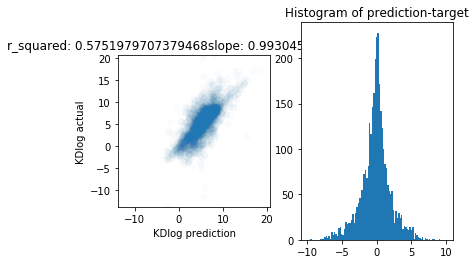

In [22]:
plot_preds(Kd_preds[0], Kd_preds[1], target_name)

In [86]:
Kd_learn.save('Kd_embedding_r2_0.6')

# Try weight decay (regularization). Default is 1e-2 as used above. There is little difference between 1e-1 and 1e-2

In [13]:
Kd_learn = collab_learner(Kd_data, n_factors=20, y_range=[-15, 25], wd=1e-1)

In [14]:
Kd_learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


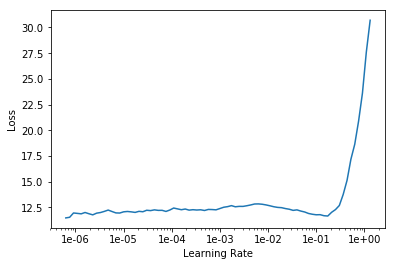

In [15]:
Kd_learn.recorder.plot()

In [16]:
Kd_learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss
1,8.120308,7.666423
2,4.853170,5.523676
3,2.751787,5.155199
4,1.735300,4.999946
5,1.176487,4.990834


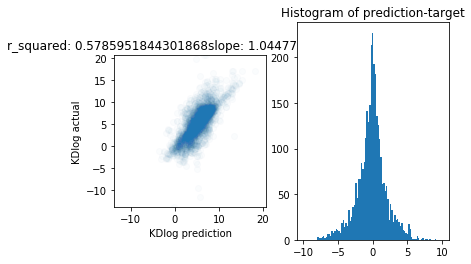

In [17]:
Kd_preds = Kd_learn.get_preds(ds_type=DatasetType.Valid)
plot_preds(Kd_preds[0], Kd_preds[1], target_name)

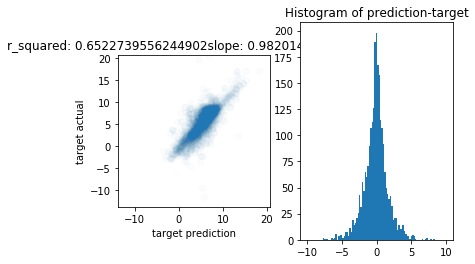

In [18]:
# get rid of those cold starts
Kd_learn_valid_df = pd.DataFrame(data=[str(i).split(';')[0] for i in list(Kd_learn.data.valid_ds.x)],
                                 columns=['compound_id'])
Kd_learn_valid_df['target_id'] = [str(i).split(';')[1] for i in list(Kd_learn.data.valid_ds.x)]
Kd_learn_valid_df['prediction'] = Kd_preds[0]
Kd_learn_valid_df['target'] = Kd_preds[1]
plot_preds(np.array(Kd_learn_valid_df[(~Kd_learn_valid_df.compound_id.str.contains('#na#'))&
                                     (~Kd_learn_valid_df.target_id.str.contains('#na#'))]['prediction']),
           np.array(Kd_learn_valid_df[~Kd_learn_valid_df.compound_id.str.contains('#na#')&
                                     (~Kd_learn_valid_df.target_id.str.contains('#na#'))]['target']))

# Try 10X faster and 10X lower learning rate. It's interesting that 5e-3 is the best. Similar to what Jeremy found for MovieLens data.

### lr = 5e-2

In [21]:
Kd_learn = collab_learner(Kd_data, n_factors=20, y_range=[-15, 25])
Kd_learn.fit_one_cycle(10, 5e-2)

epoch,train_loss,valid_loss
1,6.417176,6.560821
2,15.631054,18.196354
3,37.586300,34.687431
4,43.851486,36.916115
5,40.031815,27.955383
6,28.722246,19.873878
7,17.183010,12.312285
8,9.305803,8.077348
9,4.113434,6.622826
10,1.799497,6.525928


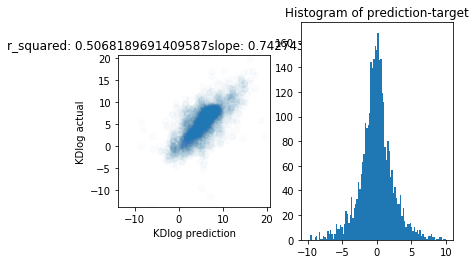

In [22]:
Kd_preds = Kd_learn.get_preds(ds_type=DatasetType.Valid)
plot_preds(Kd_preds[0], Kd_preds[1], target_name)

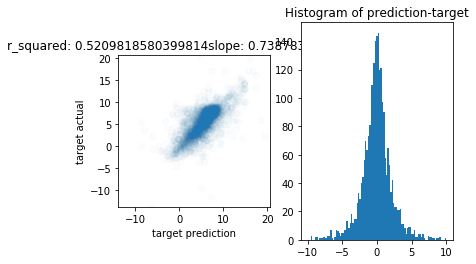

In [23]:
# get rid of those cold starts
Kd_learn_valid_df = pd.DataFrame(data=[str(i).split(';')[0] for i in list(Kd_learn.data.valid_ds.x)],
                                 columns=['compound_id'])
Kd_learn_valid_df['target_id'] = [str(i).split(';')[1] for i in list(Kd_learn.data.valid_ds.x)]
Kd_learn_valid_df['prediction'] = Kd_preds[0]
Kd_learn_valid_df['target'] = Kd_preds[1]
plot_preds(np.array(Kd_learn_valid_df[(~Kd_learn_valid_df.compound_id.str.contains('#na#'))&
                                     (~Kd_learn_valid_df.target_id.str.contains('#na#'))]['prediction']),
           np.array(Kd_learn_valid_df[~Kd_learn_valid_df.compound_id.str.contains('#na#')&
                                     (~Kd_learn_valid_df.target_id.str.contains('#na#'))]['target']))

### lr = 5e-4

In [24]:
Kd_learn = collab_learner(Kd_data, n_factors=20, y_range=[-15, 25])
Kd_learn.fit_one_cycle(10, 5e-4)

epoch,train_loss,valid_loss
1,11.910674,11.683726
2,10.521902,10.659747
3,9.360650,9.085281
4,7.221163,7.903999
5,6.045321,7.173052
6,5.252468,6.734390
7,4.527296,6.491581
8,4.055036,6.373045
9,3.810684,6.328660
10,4.172243,6.322311


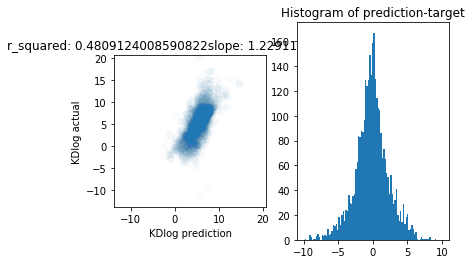

In [25]:
Kd_preds = Kd_learn.get_preds(ds_type=DatasetType.Valid)
plot_preds(Kd_preds[0], Kd_preds[1], target_name)

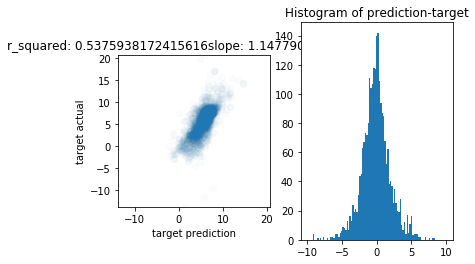

In [26]:
# get rid of those cold starts
Kd_learn_valid_df = pd.DataFrame(data=[str(i).split(';')[0] for i in list(Kd_learn.data.valid_ds.x)],
                                 columns=['compound_id'])
Kd_learn_valid_df['target_id'] = [str(i).split(';')[1] for i in list(Kd_learn.data.valid_ds.x)]
Kd_learn_valid_df['prediction'] = Kd_preds[0]
Kd_learn_valid_df['target'] = Kd_preds[1]
plot_preds(np.array(Kd_learn_valid_df[(~Kd_learn_valid_df.compound_id.str.contains('#na#'))&
                                     (~Kd_learn_valid_df.target_id.str.contains('#na#'))]['prediction']),
           np.array(Kd_learn_valid_df[~Kd_learn_valid_df.compound_id.str.contains('#na#')&
                                     (~Kd_learn_valid_df.target_id.str.contains('#na#'))]['target']))

# Try n_factor = 10, 40, 50, 60 and 80. n_factor = 50 is better.

### n_factor = 10

In [32]:
Kd_learn = collab_learner(Kd_data, n_factors=10, y_range=[-15, 25], wd=1e-1)
Kd_learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


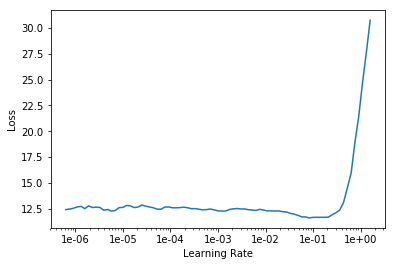

In [33]:
Kd_learn.recorder.plot()

In [34]:
Kd_learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss
1,8.454808,7.874775
2,5.140191,5.658759
3,3.240876,5.223125
4,2.149196,5.093817
5,1.663888,5.086522


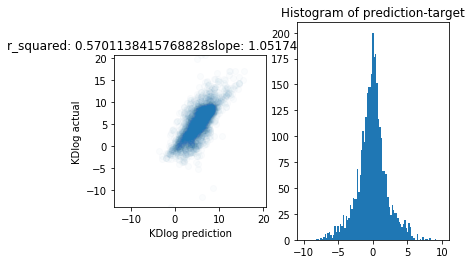

In [35]:
Kd_preds = Kd_learn.get_preds(ds_type=DatasetType.Valid)
plot_preds(Kd_preds[0], Kd_preds[1], target_name)

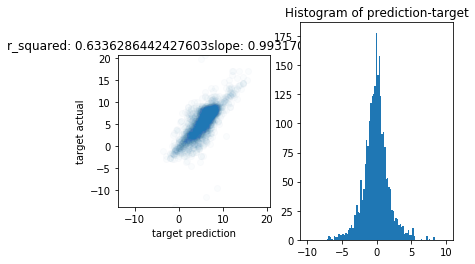

In [36]:
# get rid of those cold starts
Kd_learn_valid_df = pd.DataFrame(data=[str(i).split(';')[0] for i in list(Kd_learn.data.valid_ds.x)],
                                 columns=['compound_id'])
Kd_learn_valid_df['target_id'] = [str(i).split(';')[1] for i in list(Kd_learn.data.valid_ds.x)]
Kd_learn_valid_df['prediction'] = Kd_preds[0]
Kd_learn_valid_df['target'] = Kd_preds[1]
plot_preds(np.array(Kd_learn_valid_df[(~Kd_learn_valid_df.compound_id.str.contains('#na#'))&
                                     (~Kd_learn_valid_df.target_id.str.contains('#na#'))]['prediction']),
           np.array(Kd_learn_valid_df[~Kd_learn_valid_df.compound_id.str.contains('#na#')&
                                     (~Kd_learn_valid_df.target_id.str.contains('#na#'))]['target']))

### n_factor = 40

In [37]:
Kd_learn = collab_learner(Kd_data, n_factors=40, y_range=[-15, 25], wd=1e-1)
Kd_learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


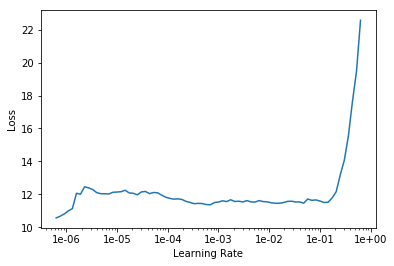

In [38]:
Kd_learn.recorder.plot()

In [39]:
Kd_learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss
1,8.194882,7.510364
2,4.669420,5.595807
3,2.537656,5.249796
4,1.466760,5.057349
5,1.140410,5.035991


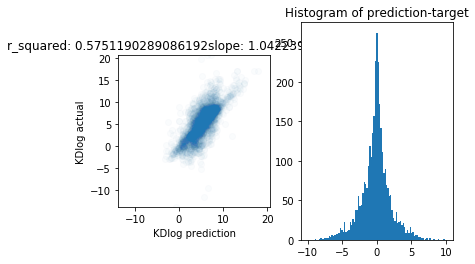

In [40]:
Kd_preds = Kd_learn.get_preds(ds_type=DatasetType.Valid)
plot_preds(Kd_preds[0], Kd_preds[1], target_name)

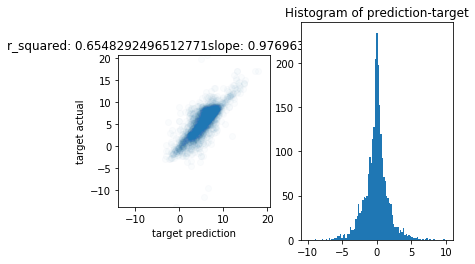

In [41]:
# get rid of those cold starts
Kd_learn_valid_df = pd.DataFrame(data=[str(i).split(';')[0] for i in list(Kd_learn.data.valid_ds.x)],
                                 columns=['compound_id'])
Kd_learn_valid_df['target_id'] = [str(i).split(';')[1] for i in list(Kd_learn.data.valid_ds.x)]
Kd_learn_valid_df['prediction'] = Kd_preds[0]
Kd_learn_valid_df['target'] = Kd_preds[1]
plot_preds(np.array(Kd_learn_valid_df[(~Kd_learn_valid_df.compound_id.str.contains('#na#'))&
                                     (~Kd_learn_valid_df.target_id.str.contains('#na#'))]['prediction']),
           np.array(Kd_learn_valid_df[~Kd_learn_valid_df.compound_id.str.contains('#na#')&
                                     (~Kd_learn_valid_df.target_id.str.contains('#na#'))]['target']))

### n_factor = 80

In [42]:
Kd_learn = collab_learner(Kd_data, n_factors=80, y_range=[-15, 25], wd=1e-1)
Kd_learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


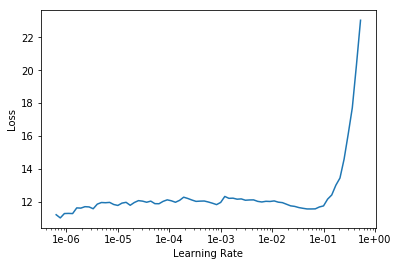

In [43]:
Kd_learn.recorder.plot()

In [44]:
Kd_learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss
1,7.636324,7.266421
2,4.675344,5.664279
3,2.760693,5.392367
4,1.734282,5.165274
5,0.911765,5.148204


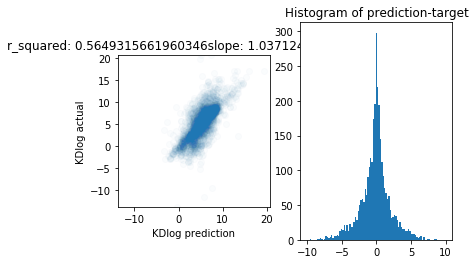

In [45]:
Kd_preds = Kd_learn.get_preds(ds_type=DatasetType.Valid)
plot_preds(Kd_preds[0], Kd_preds[1], target_name)

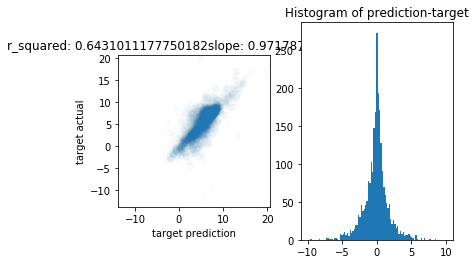

In [46]:
# get rid of those cold starts
Kd_learn_valid_df = pd.DataFrame(data=[str(i).split(';')[0] for i in list(Kd_learn.data.valid_ds.x)],
                                 columns=['compound_id'])
Kd_learn_valid_df['target_id'] = [str(i).split(';')[1] for i in list(Kd_learn.data.valid_ds.x)]
Kd_learn_valid_df['prediction'] = Kd_preds[0]
Kd_learn_valid_df['target'] = Kd_preds[1]
plot_preds(np.array(Kd_learn_valid_df[(~Kd_learn_valid_df.compound_id.str.contains('#na#'))&
                                     (~Kd_learn_valid_df.target_id.str.contains('#na#'))]['prediction']),
           np.array(Kd_learn_valid_df[~Kd_learn_valid_df.compound_id.str.contains('#na#')&
                                     (~Kd_learn_valid_df.target_id.str.contains('#na#'))]['target']))

### n_factor = 50

In [17]:
Kd_learn = collab_learner(Kd_data, n_factors=50, y_range=[-15, 25], wd=1e-1)
Kd_learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


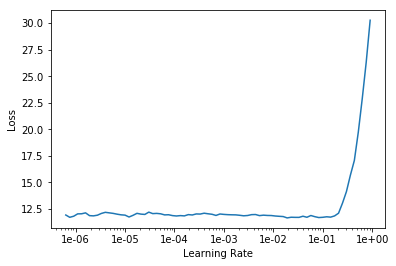

In [18]:
Kd_learn.recorder.plot()

In [19]:
Kd_learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss
1,8.010823,7.407130
2,4.460878,5.535008
3,2.695814,5.212233
4,1.487072,5.057298
5,0.879008,5.038310


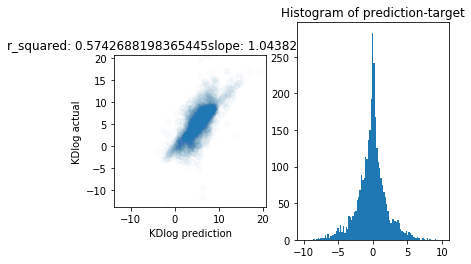

In [20]:
Kd_preds = Kd_learn.get_preds(ds_type=DatasetType.Valid)
plot_preds(Kd_preds[0], Kd_preds[1], target_name)

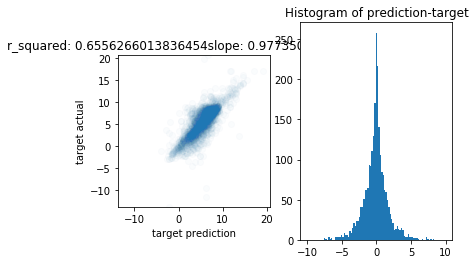

In [21]:
# get rid of those cold starts
Kd_learn_valid_df = pd.DataFrame(data=[str(i).split(';')[0] for i in list(Kd_learn.data.valid_ds.x)],
                                 columns=['compound_id'])
Kd_learn_valid_df['target_id'] = [str(i).split(';')[1] for i in list(Kd_learn.data.valid_ds.x)]
Kd_learn_valid_df['prediction'] = Kd_preds[0]
Kd_learn_valid_df['target'] = Kd_preds[1]
plot_preds(np.array(Kd_learn_valid_df[(~Kd_learn_valid_df.compound_id.str.contains('#na#'))&
                                     (~Kd_learn_valid_df.target_id.str.contains('#na#'))]['prediction']),
           np.array(Kd_learn_valid_df[~Kd_learn_valid_df.compound_id.str.contains('#na#')&
                                     (~Kd_learn_valid_df.target_id.str.contains('#na#'))]['target']))

### n_factor = 60

In [23]:
Kd_learn = collab_learner(Kd_data, n_factors=60, y_range=[-15, 25], wd=1e-1)
Kd_learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


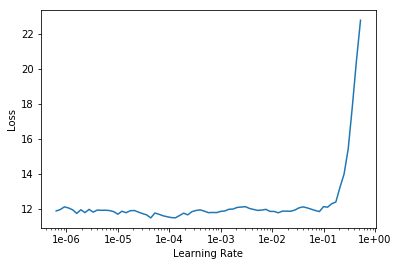

In [24]:
Kd_learn.recorder.plot()

In [25]:
Kd_learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss
1,7.841291,7.378654
2,4.823155,5.635166
3,2.650817,5.351866
4,1.530469,5.107858
5,0.729372,5.077075


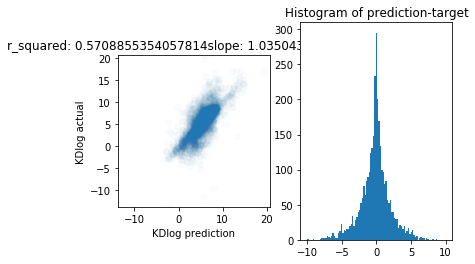

In [26]:
Kd_preds = Kd_learn.get_preds(ds_type=DatasetType.Valid)
plot_preds(Kd_preds[0], Kd_preds[1], target_name)

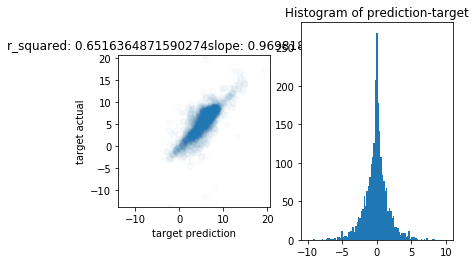

In [27]:
# get rid of those cold starts
Kd_learn_valid_df = pd.DataFrame(data=[str(i).split(';')[0] for i in list(Kd_learn.data.valid_ds.x)],
                                 columns=['compound_id'])
Kd_learn_valid_df['target_id'] = [str(i).split(';')[1] for i in list(Kd_learn.data.valid_ds.x)]
Kd_learn_valid_df['prediction'] = Kd_preds[0]
Kd_learn_valid_df['target'] = Kd_preds[1]
plot_preds(np.array(Kd_learn_valid_df[(~Kd_learn_valid_df.compound_id.str.contains('#na#'))&
                                     (~Kd_learn_valid_df.target_id.str.contains('#na#'))]['prediction']),
           np.array(Kd_learn_valid_df[~Kd_learn_valid_df.compound_id.str.contains('#na#')&
                                     (~Kd_learn_valid_df.target_id.str.contains('#na#'))]['target']))

# Try PCA with n_factor = 50

In [23]:
Kd_learn = collab_learner(Kd_data, n_factors=50, y_range=[-15, 25], wd=1e-1)
Kd_learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [24]:
Kd_learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss
1,7.966620,7.352792
2,4.815611,5.679032
3,2.512292,5.273963
4,1.678032,5.075756
5,1.003703,5.054675


In [25]:
np.sum(Kd_learn_valid_df.target_id.str.contains('#na#'))

20

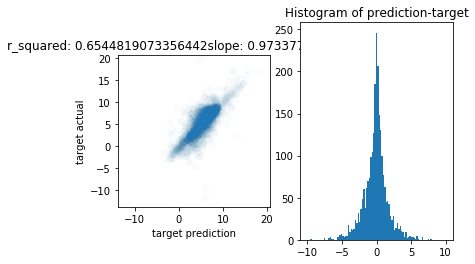

In [26]:
# get rid of those cold starts
Kd_preds = Kd_learn.get_preds(ds_type=DatasetType.Valid)
Kd_learn_valid_df = pd.DataFrame(data=[str(i).split(';')[0] for i in list(Kd_learn.data.valid_ds.x)],
                                 columns=['compound_id'])
Kd_learn_valid_df['target_id'] = [str(i).split(';')[1] for i in list(Kd_learn.data.valid_ds.x)]
Kd_learn_valid_df['prediction'] = Kd_preds[0]
Kd_learn_valid_df['target'] = Kd_preds[1]
plot_preds(np.array(Kd_learn_valid_df[(~Kd_learn_valid_df.compound_id.str.contains('#na#'))&
                                     (~Kd_learn_valid_df.target_id.str.contains('#na#'))]['prediction']),
           np.array(Kd_learn_valid_df[~Kd_learn_valid_df.compound_id.str.contains('#na#')&
                                     (~Kd_learn_valid_df.target_id.str.contains('#na#'))]['target']))

In [64]:
# find most frequent compunds
top_compounds = df_Kd.groupby('compound_id')[target_name].count().sort_values(ascending=False).index.values[:100]
top_compounds_weights = Kd_learn.weight(top_compounds, is_item=False)
top_compounds_weights_pca = top_compounds_weights.pca(3)
fac0, fac1, fac2 = top_compounds_weights_pca.t()
df_weights = pd.DataFrame({'compound_id': top_compounds,
                           'fac0': fac0,
                           'fac1': fac1,
                           'fac2': fac2})

In [67]:
df_weights.sort_values('fac0', ascending=False).head()

,compound_id,fac0,fac1,fac2
87,CHEMBL3288258,1.219978,-0.095234,-0.533590
89,CHEMBL3288259,0.921105,-0.181535,-0.518782
88,CHEMBL3288260,0.687963,0.058024,-0.162433
58,CHEMBL278041,0.360749,-0.052817,0.291996
48,CHEMBL513909,0.261515,-0.025990,0.185168


In [70]:
df_weights.sort_values('fac1', ascending=False).head()

,compound_id,fac0,fac1,fac2
14,CHEMBL31965,-0.000443,0.709019,-0.280204
57,CHEMBL1173655,0.143278,0.663073,-0.432001
42,CHEMBL180022,-0.108654,0.647305,-0.234035
30,CHEMBL607707,-0.099539,0.579548,-0.267264
22,CHEMBL553,-0.006057,0.499223,-0.242597


In [71]:
df_weights.sort_values('fac2', ascending=False).head()

,compound_id,fac0,fac1,fac2
60,CHEMBL384304,-0.109460,-0.186189,0.642485
37,CHEMBL1789941,0.183741,0.337097,0.475798
24,CHEMBL103667,-0.000644,-0.023627,0.442551
56,CHEMBL1908394,0.148236,0.094990,0.391601
18,CHEMBL1241674,-0.242797,0.010852,0.323896


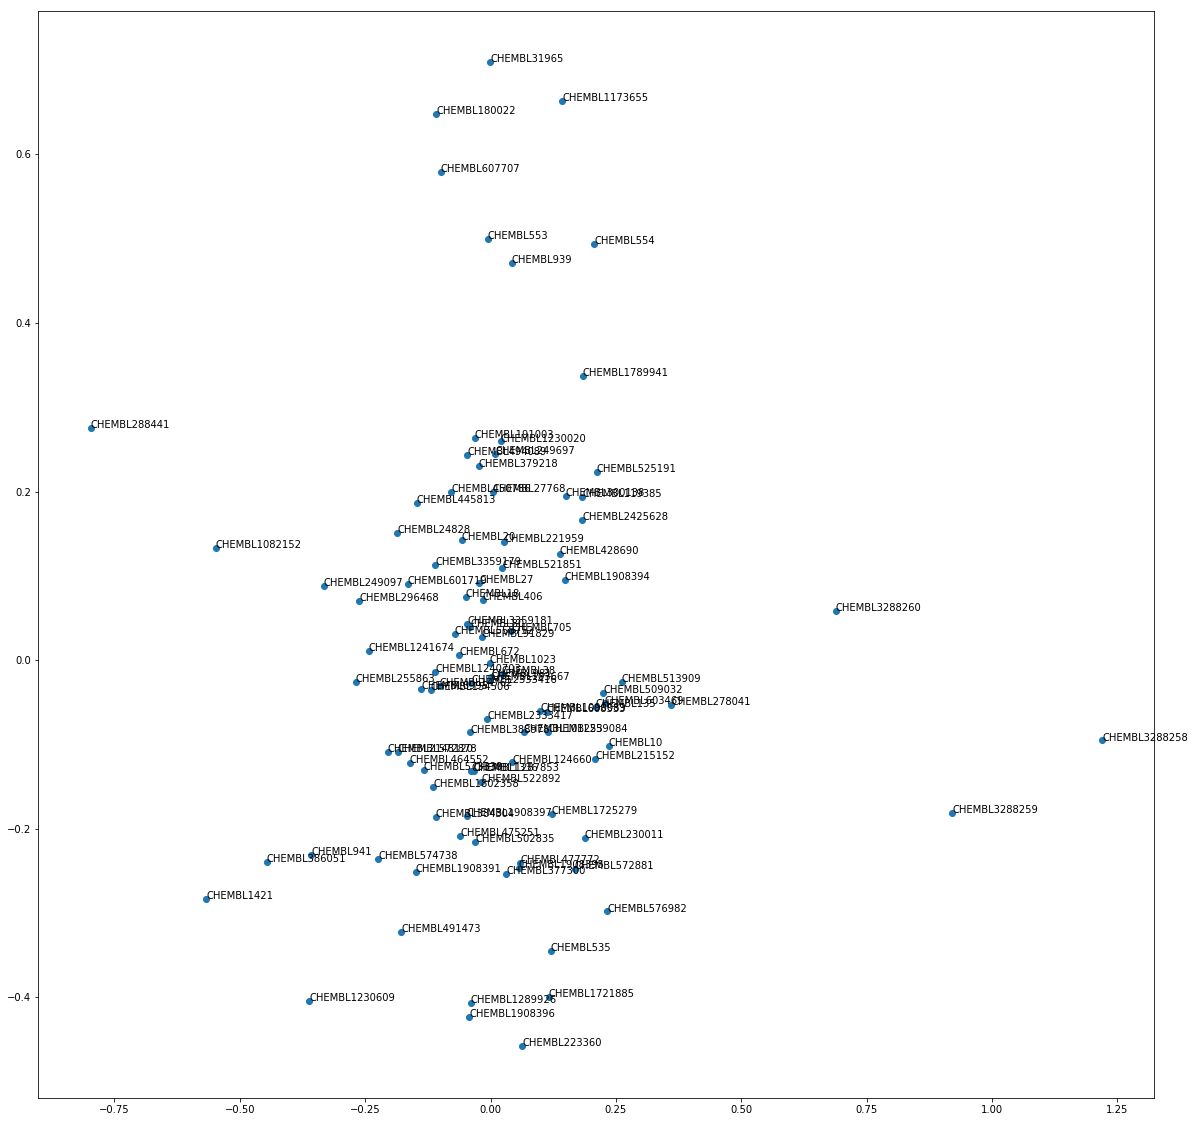

In [76]:
plt.figure(figsize=(20, 20))
plt.scatter(df_weights.fac0, df_weights.fac1)
for (id, x, y) in zip(df_weights.compound_id, df_weights.fac0, df_weights.fac1):
    plt.text(x, y, id)

In [15]:
# check CHEMBL3288258, CHEMBL3288259 CHEMBL3288260
df_Kd[(df_Kd.compound_id=='CHEMBL3288258')|
      (df_Kd.compound_id=='CHEMBL3288259')|
      (df_Kd.compound_id=='CHEMBL3288260')].groupby(['compound_id', 'target_id'])['KDlog'].mean()

compound_id    target_id
CHEMBL3288258  P01579       17.034386
               P02776       17.034386
               P05230       17.034386
               P08620       17.034386
               P09038       17.034386
               P12643       10.085809
               P12644       19.336971
               P13500       19.336971
               P13501       17.034386
               P15692       11.097410
               P19875       19.336971
               P21781       17.034386
               P22004       19.336971
               P48061       11.251561
               P51671       17.034386
               P56704       19.336971
               Q15465       10.203592
               Q8N474       19.336971
               Q99075       17.034386
CHEMBL3288259  P01579        9.210340
               P02776       17.034386
               P05230        8.987197
               P08620       17.034386
               P09038        6.907755
               P12643       10.736397
               P12644    

In [27]:
# find most frequent kinase
top_kinase = df_Kd.groupby('target_id')[target_name].count().sort_values(ascending=False).index.values[:100]
top_kinase_weights = Kd_learn.weight(top_kinase, is_item=True)
top_kinase_weights_pca = top_kinase_weights.pca(3)
fac0, fac1, fac2 = top_kinase_weights_pca.t()
df_kinase_weights = pd.DataFrame({'target_id': top_kinase,
                           'fac0': fac0,
                           'fac1': fac1,
                           'fac2': fac2})

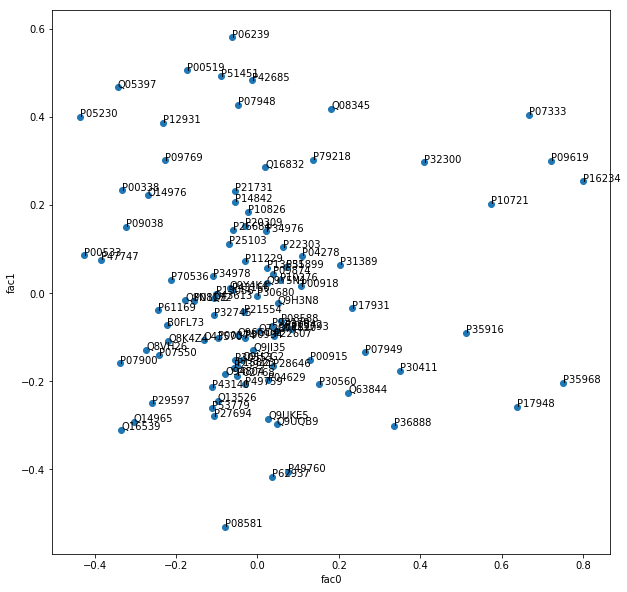

In [32]:
plt.figure(figsize=(10, 10))
plt.scatter(df_kinase_weights.fac0, df_kinase_weights.fac1)
plt.xlabel('fac0')
plt.ylabel('fac1')
for (id, x, y) in zip(df_kinase_weights.target_id, df_kinase_weights.fac0, df_kinase_weights.fac1):
    plt.text(x, y, id)

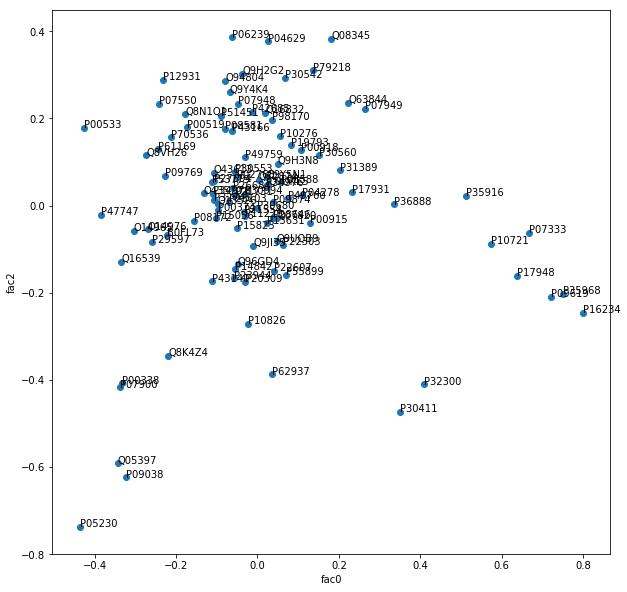

In [34]:
plt.figure(figsize=(10, 10))
plt.scatter(df_kinase_weights.fac0, df_kinase_weights.fac2)
plt.xlabel('fac0')
plt.ylabel('fac2')
for (id, x, y) in zip(df_kinase_weights.target_id, df_kinase_weights.fac0, df_kinase_weights.fac2):
    plt.text(x, y, id)

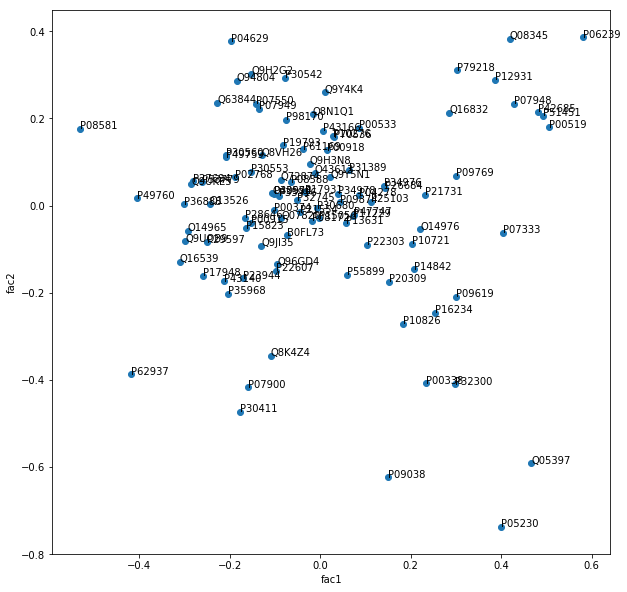

In [35]:
plt.figure(figsize=(10, 10))
plt.scatter(df_kinase_weights.fac1, df_kinase_weights.fac2)
plt.xlabel('fac1')
plt.ylabel('fac2')
for (id, x, y) in zip(df_kinase_weights.target_id, df_kinase_weights.fac1, df_kinase_weights.fac2):
    plt.text(x, y, id)

In [36]:
from sklearn.neighbors import NearestNeighbors

In [39]:
# find closest neighbors of each kinase using the principal components
kinase_nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(
                         df_kinase_weights[['fac0', 'fac1', 'fac2']])
distances, indices = kinase_nbrs.kneighbors(df_kinase_weights[['fac0', 'fac1', 'fac2']])
df_kinase_weights.loc[:, 'pca_NN'] = df_kinase_weights.loc[np.transpose(indices)[1], 'target_id'].values.flatten()

array([[ 0, 92],
       [ 1, 33],
       [ 2, 95],
       [ 3, 49],
       ...,
       [96, 90],
       [97, 73],
       [98, 43],
       [99, 17]])

In [72]:
df_kinase_weights.head()

,target_id,fac0,fac1,fac2,pca_NN
0,P00519,-0.172160,0.505359,0.179844,P51451
1,P00533,-0.425369,0.085236,0.178584,P47747
2,P36888,0.336407,-0.301593,0.002607,P30560
3,P10721,0.573825,0.202290,-0.087545,P09619
4,P00918,0.107040,0.015068,0.127067,P10276


In [42]:
df_kinase_weights.loc[0, :]

target_id      P00519
fac0         -0.17216
fac1         0.505359
fac2         0.179844
Name: 0, dtype: object

# grid search: lr is the most important hyperparameter. For wd or n_factors, there are always good parameter combinations, but for a bad lr, it would be hard to get a good result.

In [17]:
np.logspace(-3, 0, 4)

array([0.001, 0.01 , 0.1  , 1.   ])

In [24]:
wds = np.logspace(-3, 0, 4)
lrs = np.logspace(-4, -1, 4) * 0.5
n_factors = np.linspace(10, 100, 10)
df_grid_search = pd.DataFrame(columns=['wd', 'lr', 'n_factor', 'r2'])
for (wd, lr, n_factor) in itertools.product(wds, lrs, n_factors):
    print(wd, lr, n_factor)
    Kd_learn = collab_learner(Kd_data, n_factors=int(n_factor), y_range=[-15, 25], wd=wd)
    Kd_learn.fit_one_cycle(5, lr)
    Kd_preds = Kd_learn.get_preds(ds_type=DatasetType.Valid)
    Kd_learn_valid_df = pd.DataFrame(data=[str(i).split(';')[0] for i in list(Kd_learn.data.valid_ds.x)],
                                 columns=['compound_id'])
    Kd_learn_valid_df['target_id'] = [str(i).split(';')[1] for i in list(Kd_learn.data.valid_ds.x)]
    Kd_learn_valid_df['prediction'] = Kd_preds[0]
    Kd_learn_valid_df['target'] = Kd_preds[1]
    r_value = stats.linregress(np.array(Kd_learn_valid_df[(~Kd_learn_valid_df.compound_id.str.contains('#na#'))&
                                                         (~Kd_learn_valid_df.target_id.str.contains('#na#'))]['prediction']),
           np.array(Kd_learn_valid_df[~Kd_learn_valid_df.compound_id.str.contains('#na#')]['target']))[2]
    df_grid_search = df_grid_search.append({'wd': wd, 'lr': lr, 'n_factor': n_factor, 'r2': r_value**2}, 
                                           ignore_index = True)


Text(0.5,0,'n_factor')

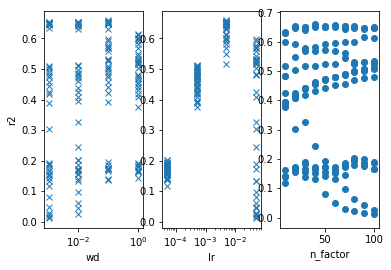

In [35]:
fig, ax = plt.subplots(1, 3)
ax[0].semilogx(df_grid_search.wd, df_grid_search.r2, 'x')
ax[0].set_xlabel('wd')
ax[0].set_ylabel('r2')
ax[1].semilogx(df_grid_search.lr, df_grid_search.r2, 'x')
ax[1].set_xlabel('lr')
ax[2].scatter(df_grid_search.n_factor, df_grid_search.r2)
ax[2].set_xlabel('n_factor')

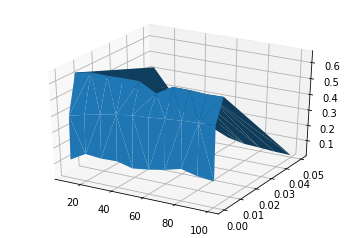

In [44]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(df_grid_search.n_factor, df_grid_search.lr, df_grid_search.r2)

In [45]:
df_grid_search.sort_values('r2', ascending=False)

,wd,lr,n_factor,r2
103,0.100,0.00500,40.0,0.658845
105,0.100,0.00500,60.0,0.656343
66,0.010,0.00500,70.0,0.653241
106,0.100,0.00500,70.0,0.653040
23,0.001,0.00500,40.0,0.652906
65,0.010,0.00500,60.0,0.652796
21,0.001,0.00500,20.0,0.652655
104,0.100,0.00500,50.0,0.652549
67,0.010,0.00500,80.0,0.652447
102,0.100,0.00500,30.0,0.651877


# embedding NN (https://towardsdatascience.com/collaborative-filtering-with-fastai-3dbdd4ef4f00)

In [269]:
Kd_NN = collab_learner(Kd_data, use_nn=True, 
                       emb_szs={'compound_id': 40, 'target_id':40}, layers=[256, 128], y_range=(-20, 30))

In [270]:
Kd_NN.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


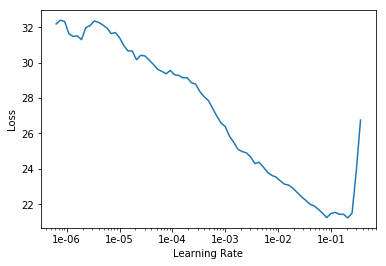

In [271]:
Kd_NN.recorder.plot()

In [272]:
Kd_NN.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss
1,8.092835,7.002777
2,7.083485,6.826031
3,5.260640,6.407361
4,4.042236,5.750410
5,3.379128,5.433368
6,2.762931,5.120790
7,2.096077,5.052482
8,1.783967,4.964086
9,1.583162,5.192410
10,1.353708,5.019313


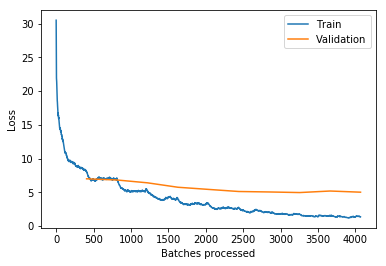

In [273]:
Kd_NN.recorder.plot_losses()

In [274]:
Kd_NN.show_results()

compound_id,target_id,target,prediction
CHEMBL2024149,P0DMS8,-0.8278220891952515,3.687488555908203
CHEMBL1544,P10827,-2.8473122119903564,-2.4090042114257812
CHEMBL265556,P30968,0.0,0.11651229858398438
CHEMBL1721885,Q9Y4K4,5.703782558441162,5.274375915527344
CHEMBL522892,Q16513,9.200289726257324,8.28076171875


In [275]:
Kd_NN_preds = Kd_NN.get_preds()

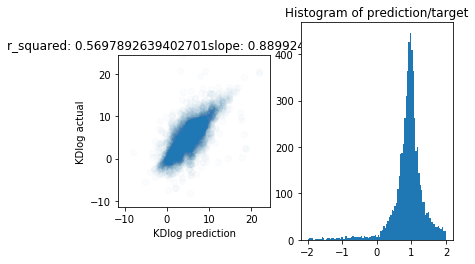

In [276]:
plot_preds(Kd_NN_preds[0].flatten(), Kd_NN_preds[1], target_name)

## TODO
1. #na# issue. see this https://forums.fast.ai/t/tabular-issue-spliting-to-validation-results-in-random-na-in-data/37268 (done)
1. explore the effect of embedding